# Introduction

### Solution 1: 4-GPU Pod (vLLM Qwen DP1 TP4) 

Each pod hosts 1 vLLM Qwen instance. When multiple pods are scheduled in the DOKS cluster without explicit NUMA affinity, CPU, memory, and GPU resources can become misaligned, leading to suboptimal and variable performance.

The deployment manifest on DOKS:
- 4-gpu-pod-dp1-tp4/325-vllm0123.yaml
- 4-gpu-pod-dp1-tp4/325-vllm4567.yaml
- 4-gpu-pod-dp1-tp4/service0123.yaml
- 4-gpu-pod-dp1-tp4/service4567.yaml

Test cases and results by chat replay:
- 4-gpu-pod-dp1-tp4/results-chat-replay

Test cases and results by vllm bench serve:
- 4-gpu-pod-dp1-tp4/test_cases_vllm_bench_serve.csv
- Qwen3-235B-A22B-Instruct-2507-FP8_vllm_20260225_all.csv
  
### Solution 2: 8-GPU Pod (vLLM Qwen DP2 TP4) 

The pod contains 2 vLLM Qwen instances. Within the pod, numactl and NCCL/RCCL environment variables can be used to proactively enforce NUMA alignment across CPU, memory, and GPU for each vLLM instance. While this approach can improve performance and reduce GPU resource fragmentation on nodes, it may require re-engineering efforts, including redesign, testing, and validation.

The deployment manifest on DOKS:
- 8-gpu-pod-dp2-tp4/325-vllm-dp2-tp4.yaml
- 8-gpu-pod-dp2-tp4/service-dp2-tp4.yaml

Test cases and results by chat replay:
- 8-gpu-pod-dp2-tp4/results-chat-replay

Test cases and results by vllm bench serve:
- 8-gpu-pod-dp2-tp4/test_cases_vllm_bench_serve.csv
- Qwen3-235B-A22B-Instruct-2507-FP8_vllm_20260225_all.csv

# About the testing environments, tools and methodology

All tests were conducted using both **chat replay** and **vLLM bench serve** to enable cross-verification.

Chat replay was performed on a single node, while vLLM bench serve tested across 4 nodes, yielding consistent results. Leveraging this cross-verification, we can extrapolate insights from chat replay to estimate performance across multiple nodes.

The test environments used newly-provisioned nodes with no prior workloads. The results were
highly reproducible across both tools, provided the tests run for a sufficient duration and include an adequate number of cases.

The production environment is more complex, with nodes already running multiple and diverse workloads. Consequently, performance data is expected to vary within a certain range rather than remain constant; however, the overall pattern should still be observable.

# Concepts

### GPU Node Architecture

The AMD MI325x8 is configured with 2 NUMA nodes, meaning the system’s CPUs and memory are divided into two locality domains:
- **NUMA node 0, CPUs: 0-79**
- **NUMA node 1, CPUs: 80-159**

Each NUMA node has its own local memory and directly attached PCIe devices (GPUs, NICs), providing lower-latency access when processes run within the same node. Accessing memory or devices across NUMA nodes incurs additional latency due to inter-socket communication.

![vLLM Process Introduction](images/numa-arch.png)

### vLLM Instance Processes

When running vLLM with Qwen using 4 GPUs, two types of Python processes are created: 

- **VLLM::EngineCore** (CPU-only), 1
- **VLLM::Worker_TP** (CPU+GPU), 4
  
![vLLM Process Introduction](images/vllm-processes.png)

The **VLLM::EngineCore** process serves as the control plane and scheduler. It handles API requests, manages batching, coordinates tensor-parallel workers, and aggregates the outputs before returning responses.

For each GPU, vLLM launches a **VLLM::Worker** process. Each worker holds a shard of the model weights (for tensor parallelism), executes forward passes on its assigned GPU, maintains the GPU-resident KV cache, and participates in inter-worker communication (e.g., all-reduce) to produce the final results.

### NUMA Alignment

The execution of vLLM processes (threads) can migrate across CPU cores, particularly after I/O blocking. Without enforced NUMA alignment, threads may run on cores from different NUMA nodes, resulting in remote memory and GPU access, which can cause performance loss and variability.

By enforcing NUMA alignment, each vLLM instance can be confined to a specific NUMA node, ensuring consistent and optimal performance:

- vLLM Qwen instance on GPU 0/1/2/3, using CPU cores and memory in NUMA Node 0
- vLLM Qwen instance on GPU 4/5/6/7, using CPU cores and memory in NUMA Node 1

![NUMA1](images/numa1.png)

![NUMA1](images/numa2.png)


### Key Insights

For all processes in a vLLM Qwen instance, placing the VLLM::EngineCore process (CPU-only) on the same NUMA node as the VLLM::Worker_TP processes (CPU+GPU) is critical for overall performance. 

The EngineCore serves as the scheduler and control plane, handling batch dispatching, orchestrating tensor-parallel workers, and aggregating outputs from all Worker_TP processes. Since it communicates with all Worker_TPs for each generated token, any NUMA misalignment introduces additional latency that impacts performance significantly. 

In contrast, each Worker_TP process is largely GPU-bound: the bulk of its computation — forward passes, KV cache updates, and tensor-parallel reductions — occurs on the GPU. With optimizations such as CUDA graphs, pre-allocated GPU memory, and asynchronous streams, the CPU involvement of Worker_TP is minimal, making its NUMA placement (CPU, memory, GPU) less critical. 

**Observations indicate that the worst performance occurs when the EngineCore process migrates across CPU cores on different NUMA nodes, while Worker_TP processes also migrate across NUMA nodes in both test cases:**
- 4-gpu-pod-dp1-tp4/results-chat-replay/cross-numa-gpu0123-20260222.txt (normal)
- 4-gpu-pod-dp1-tp4/results-chat-replay/cross-numa-gpu4567-20260222.txt (worst)

# Test Results - Chat Replay

### Solution 1: 4-GPU Pod (vLLM Qwen DP1 TP4)

The performance of GPU0123 is significantly higher than that of GPU4567 because its EngineCore process remains on CPU cores within a single NUMA node.

| Metric                  | GPU1357 | GPU0246 | GPU0123 | GPU4567 |
|-------------------------|---------|---------|---------|---------|
| Total Requests          | 11232   | 11232   | 11231   | 11232   |
| Successful              | 11232   | 11232   | 11231   | 11232   |
| Failed                  | 0       | 0       | 0       | 0       |
| Average QPS             | 6.24    | 6.24    | 6.24    | 6.24    |
| Max QPS                 | 187.2   | 187.2   | 187.18  | 187.2   |
| TTFT Mean (ms)          | 566.57  | 577.1   | 386.23  | 565.51  |
| TTFT p50 (ms)           | 353.74  | 361.88  | 238.22  | 358.26  |
| TTFT p90 (ms)           | 1382.47 | 1434.28 | 854.64  | 1381.13 |
| First Chunk Mean (ms)   | 2104.24 | 2129.6  | 1485.24 | 2092.28 |
| First Chunk p90 (ms)    | 4354.22 | 4403.52 | 2949.88 | 4304.52 |
| TPOT Mean (ms)          | 66.73   | 66.91   | 51.48   | 66.22   |
| TPOT p90 (ms)           | 101.4   | 101.48  | 79.19   | 100.86  |
| Total Req Time Mean (ms)| 8921.41 | 8956.03 | 6831.36 | 8857.7  |
| Total Req Time p90 (ms) | 13714.87| 13847.97| 10428.48| 13643.59|
| Avg Prompt Tokens       | 4858.34 | 4858.34 | 4858.34 | 4858.34 |
| Avg Completion Tokens   | 125.37  | 125.36  | 125.34  | 125.36  |

### Solution 2: 8-GPU Pod (vLLM Qwen DP2 TP4) 

After enforcing NUMA alignment, we achieved the best and most consistent results.

| Metric                  | GPU0123   | GPU4567   | GPU0123<br>numa-aware | GPU4567<br>numa-aware |
|-------------------------|-----------|-----------|------------------|------------------|
| Total Requests          | 11,231    | 11,232    | 11,232           | 11,232           |
| Success Rate            | 100%      | 100%      | 100%             | 100%             |
| Average QPS             | 6.24      | 6.24      | 6.24             | 6.24             |
| Max QPS                 | 187.18    | 187.2     | 187.2            | 187.2            |
| Avg Prompt Tokens       | 4,858.34  | 4,858.34  | 4,858.34         | 4,858.34         |
| Avg Completion Tokens   | 125.34    | 125.36    | 125.33           | 125.34           |
| TTFT Mean (ms)          | 386.23    | 565.51    | 383.07           | 384.04           |
| TTFT p50 (ms)           | 238.22    | 358.26    | 234.34           | 230.63           |
| TTFT p95 (ms)           | 1188.74   | 1855.07   | 1179.97          | 1189.04          |
| TTFT p99 (ms)           | 1944.11   | 2992.36   | 1927.48          | 1986.66          |
| First Chunk Mean (ms)   | 1485.24   | 2092.28   | 1475.62          | 1471.35          |
| First Chunk p50 (ms)    | 1108.25   | 1483.86   | 1097.51          | 1094.64          |
| First Chunk p95 (ms)    | 3910.25   | 5605.89   | 3928.26          | 3874.72          |
| First Chunk p99 (ms)    | 6112.14   | 8773.09   | 6103.56          | 6062.34          |
| TPOT Mean (ms)          | 51.48     | 66.22     | 51.11            | 51.11            |
| TPOT p50 (ms)           | 47.32     | 61.45     | 46.99            | 47.03            |
| TPOT p95 (ms)           | 89.83     | 112.19    | 90.03            | 89.72            |
| TPOT p99 (ms)           | 112.26    | 130.14    | 111.61           | 112.35           |
| Total Time Mean (ms)    | 6831.36   | 8857.7    | 6781.7           | 6783.65          |
| Total Time p50 (ms)     | 6289.22   | 8224.96   | 6240.5           | 6248.51          |
| Total Time p95 (ms)     | 12251.76  | 15385.67  | 12262.65         | 12172.34         |
| Total Time p99 (ms)     | 14814.45  | 17292.3   | 14776.72         | 14820            |

# Test Results - vLLM Bench Serve

In [62]:
import json
import pandas as pd
import ast
import matplotlib.pyplot as plt
from itertools import product
import numpy
%matplotlib inline  

In [63]:
# Collected Data
df = pd.read_csv("./Qwen3-235B-A22B-Instruct-2507-FP8_vllm_20260225_all.csv")

In [64]:
df['base_url'].unique()

array(['http://mi325-vllm0123.default.svc.cluster.local:80',
       'http://mi325-vllm4567.default.svc.cluster.local:80',
       'http://vllm-8000.default.svc.cluster.local:80',
       'http://vllm-8001.default.svc.cluster.local:80'], dtype=object)

In [65]:
df['others'].unique()

array(['doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-2-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-3-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-4-1',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-2',
       'doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-3'],
      dtype=object)

In [66]:
qwen_map = {
    "http://mi325-vllm0123.default.svc.cluster.local:80": "GPU0123",
    "http://mi325-vllm4567.default.svc.cluster.local:80": "GPU4567",
    "http://vllm-8000.default.svc.cluster.local:80": "GPU0123_NUMA_AWARE",
    "http://vllm-8001.default.svc.cluster.local:80": "GPU4567_NUMA_AWARE",
}
df["qwen_instance"] = df["base_url"].map(qwen_map)

node_map = {
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-1": "atl1node212-old", # after chat replay and may be via the NodePort
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-2": "atl1node212",     # new
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-2-1": "sfo3node1874",
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-3-1": "sfo3node1868",
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-4-1": "sfo3node1879",
    "doks-1.34.1-rocm-7.0.2-vllm-gpu-0123-4567-mi325-1-3": "atl1node212",     # NUMA Aware
}
df["node_name"] = df["others"].map(node_map)

df = df.sort_values(["qwen_instance", "node_name", "num_prompts"])

In [67]:
color_map = {
    "GPU0123": "red",
    "GPU4567": "red",
    "GPU0123_NUMA_AWARE": "blue",
    "GPU4567_NUMA_AWARE": "blue"
}

In [72]:
qwen_instances = ["GPU0123", "GPU4567", "GPU0123_NUMA_AWARE", "GPU4567_NUMA_AWARE"]
node_names = [ "atl1node212" ]

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA_AWARE
Node: atl1node212, Instance: GPU4567_NUMA_AWARE


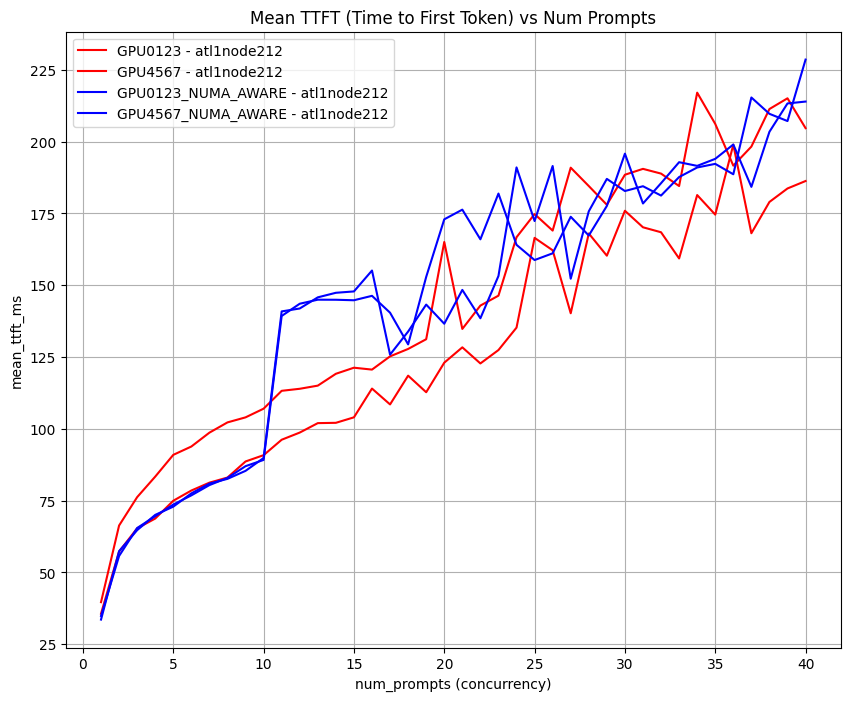

In [73]:
plt.figure(figsize=(10, 8))

for n, q in product(node_names, qwen_instances):
    print(f"Node: {n}, Instance: {q}")
    
    temp_df = df[
        (df['qwen_instance'] == q) &
        (df['node_name'] == n)
    ]

    if temp_df.empty:
        continue  # skip if no data

    plt.plot(
        temp_df["num_prompts"],
        temp_df["mean_ttft_ms"],
        #temp_df["median_ttft_ms"],
        color= color_map[q],
        label=f"{q} - {n}"
    )

# Move these OUTSIDE the loop
plt.xlabel("num_prompts (concurrency)")
plt.ylabel("mean_ttft_ms")
plt.title("Mean TTFT (Time to First Token) vs Num Prompts")
plt.legend()
plt.grid(True)

plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA_AWARE
Node: atl1node212, Instance: GPU4567_NUMA_AWARE


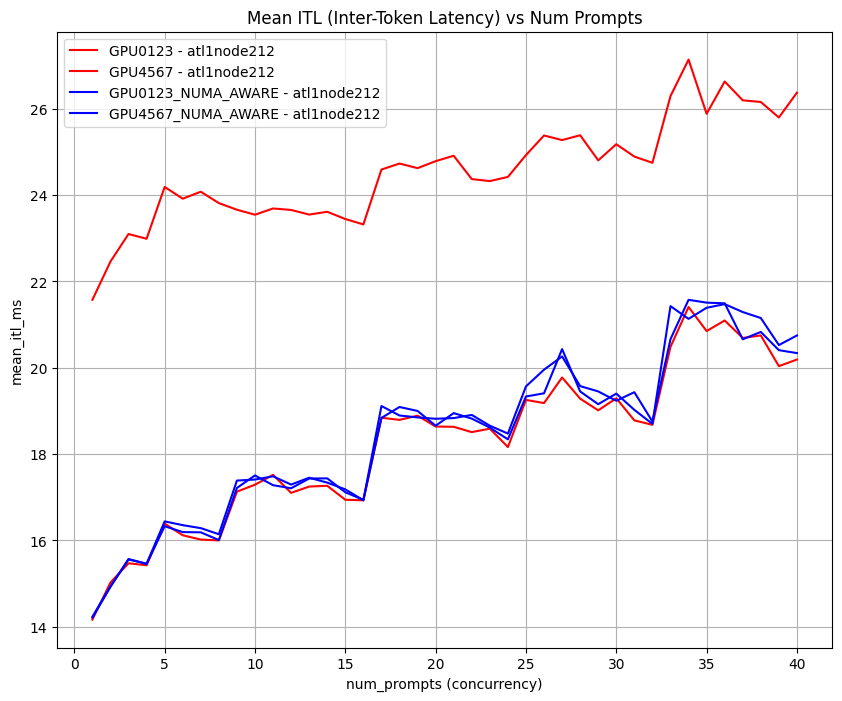

In [74]:
plt.figure(figsize=(10, 8))

for n, q in product(node_names, qwen_instances):
    print(f"Node: {n}, Instance: {q}")
    
    temp_df = df[
        (df['qwen_instance'] == q) &
        (df['node_name'] == n)
    ]

    if temp_df.empty:
        continue  # skip if no data

    plt.plot(
        temp_df["num_prompts"],
        temp_df["mean_itl_ms"],
        color= color_map[q],
        label=f"{q} - {n}"
    )

# Move these OUTSIDE the loop
plt.xlabel("num_prompts (concurrency)")
plt.ylabel("mean_itl_ms")
plt.title("Mean ITL (Inter-Token Latency) vs Num Prompts")
plt.legend()
plt.grid(True)

plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA_AWARE
Node: atl1node212, Instance: GPU4567_NUMA_AWARE


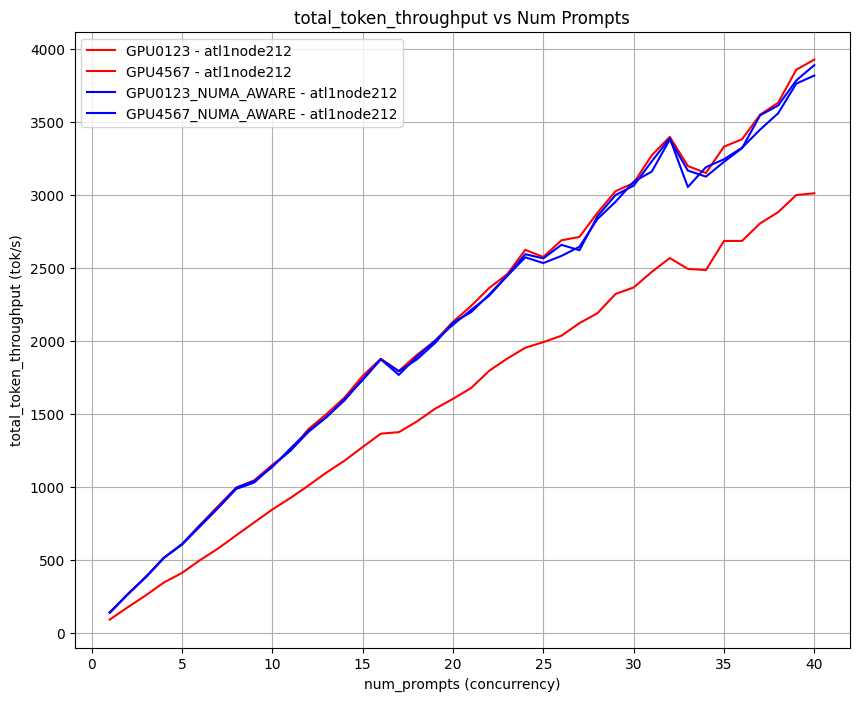

In [75]:
plt.figure(figsize=(10, 8))

for n, q in product(node_names, qwen_instances):
    print(f"Node: {n}, Instance: {q}")
    
    temp_df = df[
        (df['qwen_instance'] == q) &
        (df['node_name'] == n)
    ]

    if temp_df.empty:
        continue  # skip if no data

    plt.plot(
        temp_df["num_prompts"],
        temp_df["total_token_throughput"],
        color= color_map[q],
        label=f"{q} - {n}"
    )

# Move these OUTSIDE the loop
plt.xlabel("num_prompts (concurrency)")
plt.ylabel("total_token_throughput (tok/s)")
plt.title("total_token_throughput vs Num Prompts")
plt.legend()
plt.grid(True)

plt.show()

In [76]:
qwen_instances = ["GPU0123", "GPU4567", "GPU0123_NUMA_AWARE", "GPU4567_NUMA_AWARE"]
#node_names = [ "atl1node212-old","atl1node212", "sfo3node1868", "sfo3node1874", "sfo3node1879" ]
node_names = [ "atl1node212", "sfo3node1868", "sfo3node1874", "sfo3node1879" ]

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA_AWARE
Node: atl1node212, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1868, Instance: GPU0123
Node: sfo3node1868, Instance: GPU4567
Node: sfo3node1868, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1868, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1874, Instance: GPU0123
Node: sfo3node1874, Instance: GPU4567
Node: sfo3node1874, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1874, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1879, Instance: GPU0123
Node: sfo3node1879, Instance: GPU4567
Node: sfo3node1879, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1879, Instance: GPU4567_NUMA_AWARE


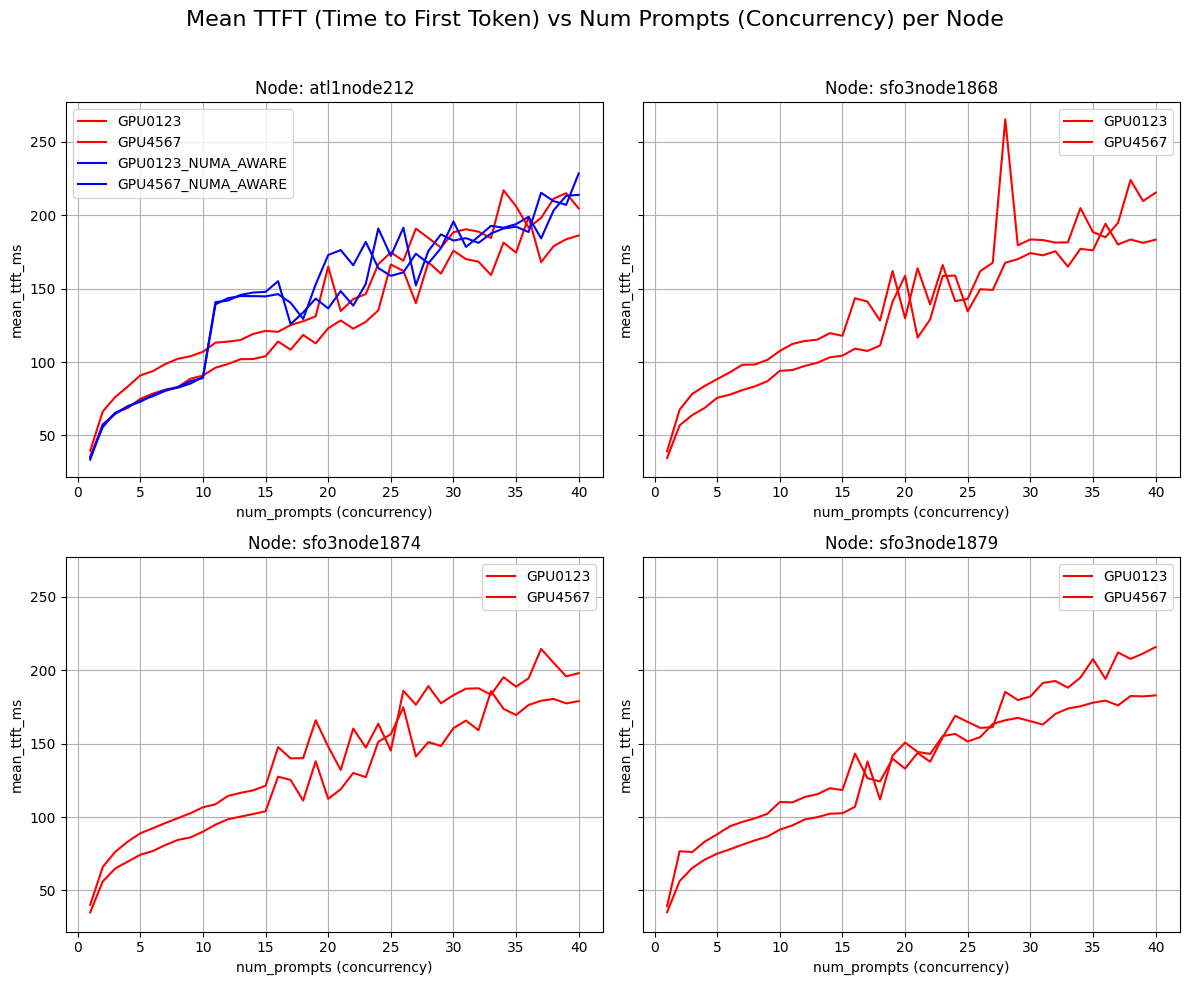

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, n in enumerate(node_names):
    ax = axes[i]
    
    for q in qwen_instances:

        print(f"Node: {n}, Instance: {q}")
        
        temp_df = df[
            (df['qwen_instance'] == q) &
            (df['node_name'] == n)
        ]
        
        if temp_df.empty:
            continue
        
        ax.plot(
            temp_df["num_prompts"],
            temp_df["mean_ttft_ms"],
            #marker="o",
            color= color_map[q],
            label=f"{q}"
        )
    
    ax.set_title(f"Node: {n}")
    ax.set_xlabel("num_prompts (concurrency)")
    ax.set_ylabel("mean_ttft_ms")
    ax.grid(True)
    ax.legend()

fig.suptitle("Mean TTFT (Time to First Token) vs Num Prompts (Concurrency) per Node", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA_AWARE
Node: atl1node212, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1868, Instance: GPU0123
Node: sfo3node1868, Instance: GPU4567
Node: sfo3node1868, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1868, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1874, Instance: GPU0123
Node: sfo3node1874, Instance: GPU4567
Node: sfo3node1874, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1874, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1879, Instance: GPU0123
Node: sfo3node1879, Instance: GPU4567
Node: sfo3node1879, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1879, Instance: GPU4567_NUMA_AWARE


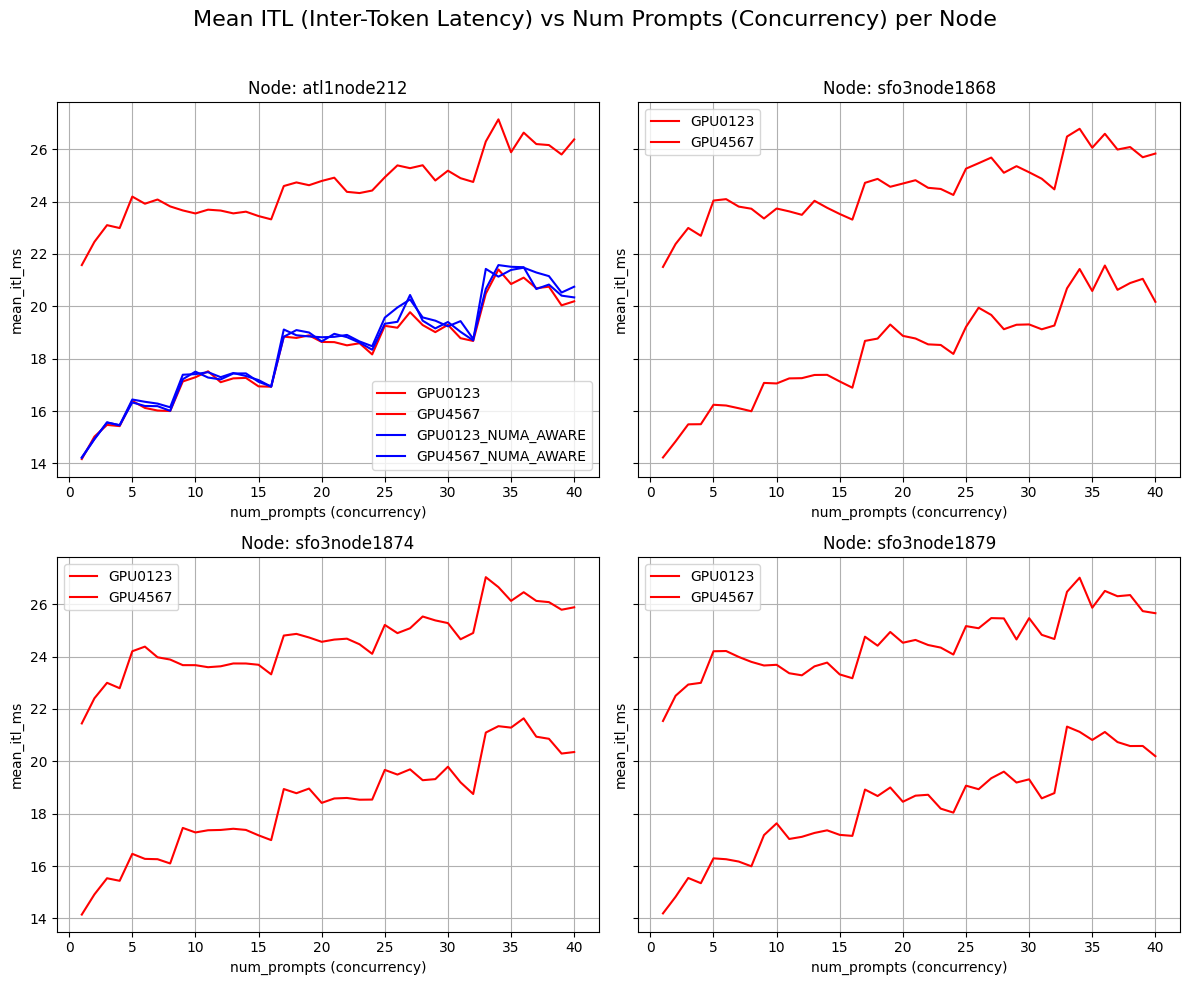

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, n in enumerate(node_names):
    ax = axes[i]
    
    for q in qwen_instances:

        print(f"Node: {n}, Instance: {q}")
        
        temp_df = df[
            (df['qwen_instance'] == q) &
            (df['node_name'] == n)
        ]
        
        if temp_df.empty:
            continue
        
        ax.plot(
            temp_df["num_prompts"],
            temp_df["mean_itl_ms"],
            #marker="o",
            color= color_map[q],
            label=f"{q}"
        )
    
    ax.set_title(f"Node: {n}")
    ax.set_xlabel("num_prompts (concurrency)")
    ax.set_ylabel("mean_itl_ms")
    ax.grid(True)
    ax.legend()

fig.suptitle("Mean ITL (Inter-Token Latency) vs Num Prompts (Concurrency) per Node", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

Node: atl1node212, Instance: GPU0123
Node: atl1node212, Instance: GPU4567
Node: atl1node212, Instance: GPU0123_NUMA_AWARE
Node: atl1node212, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1868, Instance: GPU0123
Node: sfo3node1868, Instance: GPU4567
Node: sfo3node1868, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1868, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1874, Instance: GPU0123
Node: sfo3node1874, Instance: GPU4567
Node: sfo3node1874, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1874, Instance: GPU4567_NUMA_AWARE
Node: sfo3node1879, Instance: GPU0123
Node: sfo3node1879, Instance: GPU4567
Node: sfo3node1879, Instance: GPU0123_NUMA_AWARE
Node: sfo3node1879, Instance: GPU4567_NUMA_AWARE


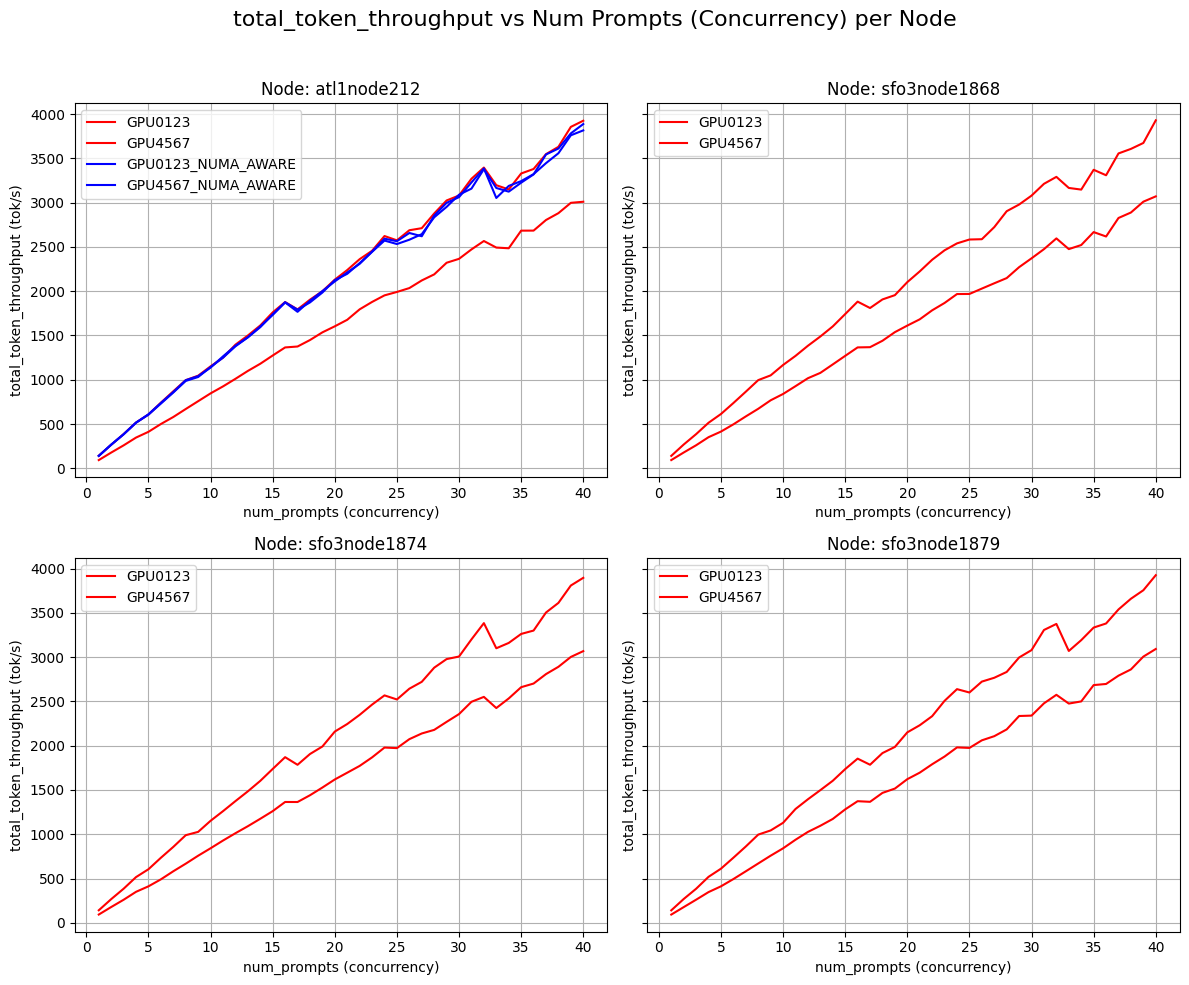

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, n in enumerate(node_names):
    ax = axes[i]
    
    for q in qwen_instances:

        print(f"Node: {n}, Instance: {q}")
        
        temp_df = df[
            (df['qwen_instance'] == q) &
            (df['node_name'] == n)
        ]
        
        if temp_df.empty:
            continue
        
        ax.plot(
            temp_df["num_prompts"],
            temp_df["total_token_throughput"],
            #marker="o",
            color= color_map[q],
            label=f"{q}"
        )
    
    ax.set_title(f"Node: {n}")
    ax.set_xlabel("num_prompts (concurrency)")
    ax.set_ylabel("total_token_throughput (tok/s)")
    ax.grid(True)
    ax.legend()

fig.suptitle("total_token_throughput vs Num Prompts (Concurrency) per Node", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()